In [4]:
!pip install --upgrade pandas

In [5]:
import os, glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

videos = [
    "video1.mp4.MP4",
    "video2.mp4.MP4",
    "video3.mp4.MP4"
]

In [6]:
import os, glob

print("Current working directory:", os.getcwd())
print("\nFiles in this folder:")
for f in os.listdir():
    if f.lower().endswith((".mp4", ".mov", ".mkv", ".avi")):
        print("  ", f)


Current working directory: C:\Users\BULAND KUMAR PRADHAN\ITS\Project Helsinki

Files in this folder:
   video1.mp4.MP4
   video2.mp4.MP4
   video3.mp4.MP4


In [ ]:
from IPython.display import Video, display

for v in videos:
    print("Preview:", v)
    display(Video(v, embed=False))


In [7]:
missing = [v for v in videos if not os.path.exists(v)]
print("Working directory:", os.getcwd())
print("Missing files:", missing)

print("\nDetected video files in folder:")
for f in os.listdir():
    if f.lower().endswith((".mp4", ".mov", ".avi", ".mkv")):
        print(" ", f)



Working directory: C:\Users\BULAND KUMAR PRADHAN\ITS\Project Helsinki
Missing files: []

Detected video files in folder:
  video1.mp4.MP4
  video2.mp4.MP4
  video3.mp4.MP4


In [8]:
def get_video_info(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return {"video": path, "error": "Cannot open (path/codec issue)"}

    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    duration = (n / fps) if fps and fps > 0 else None
    return {
        "video": path,
        "fps": round(fps, 2),
        "width": w,
        "height": h,
        "frames": n,
        "duration_s": round(duration, 2) if duration else None
    }

info_df = pd.DataFrame([get_video_info(v) for v in videos])
info_df



,video,fps,width,height,frames,duration_s
0,video1.mp4.MP4,239.76,1920,1080,9550,39.83
1,video2.mp4.MP4,239.76,1920,1080,57022,237.83
2,video3.mp4.MP4,239.76,1920,1080,18293,76.30


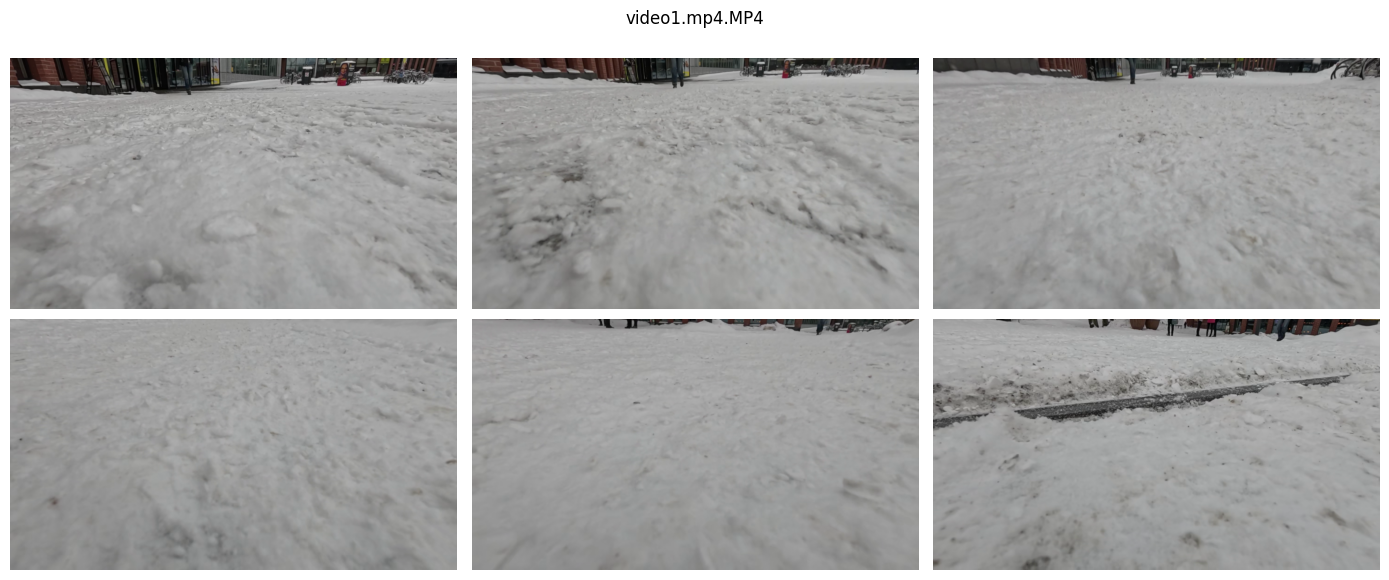

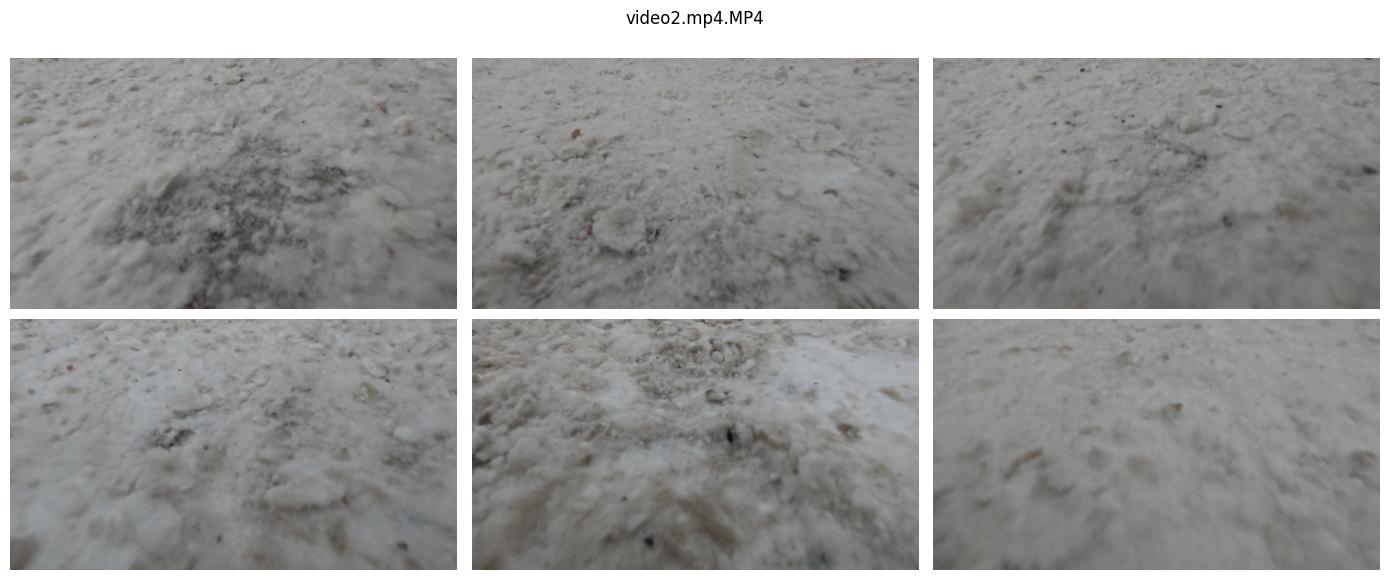

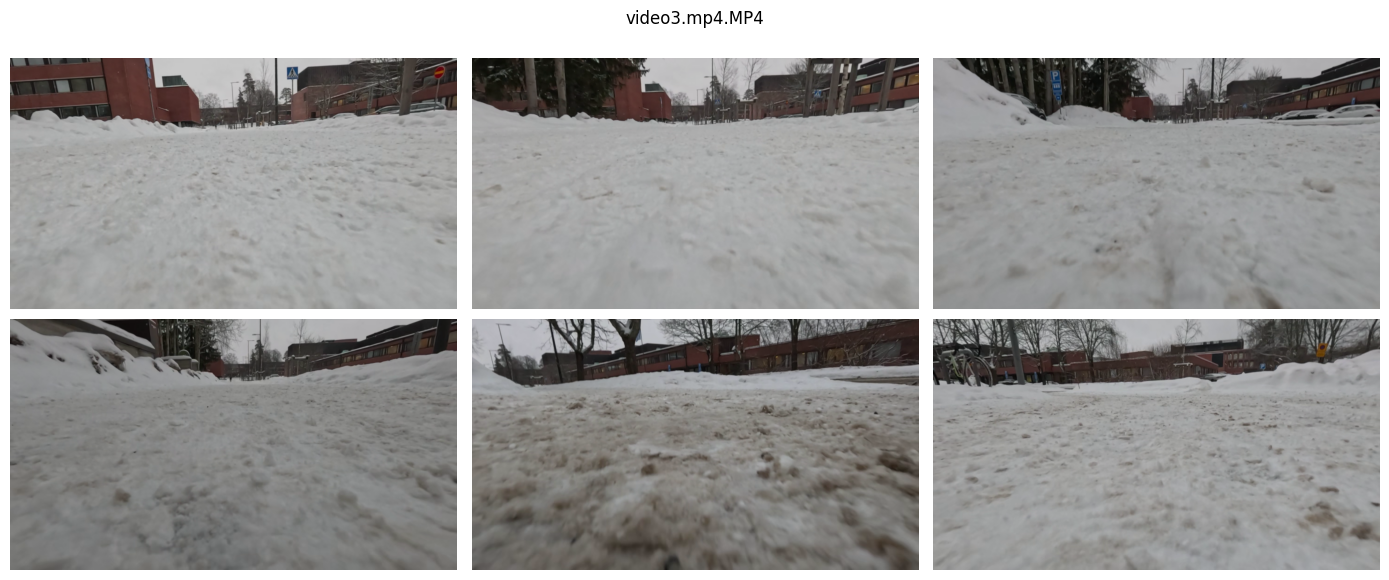

In [9]:
def show_sample_frames(video_path, n_samples=6):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Cannot open:", video_path)
        return

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = [int(total * i / (n_samples + 1)) for i in range(1, n_samples + 1)]

    frames = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        # resize for display to avoid huge outputs
        h, w = frame.shape[:2]
        if w > 900:
            frame = cv2.resize(frame, (900, int(h * 900 / w)), interpolation=cv2.INTER_AREA)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    plt.figure(figsize=(14, 6))
    plt.suptitle(video_path)
    for i, fr in enumerate(frames):
        plt.subplot(2, 3, i + 1)
        plt.imshow(fr)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

for v in videos:
    show_sample_frames(v, n_samples=6)



In [10]:
def quality_metrics_fast(video_path,
                         sample_every_n_frames=20,
                         resize_width=640,
                         max_sampled_frames=200,
                         dark_thresh=60,
                         bright_thresh=200,
                         blur_thresh=60):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return {"video": video_path, "error": "Cannot open"}

    blur_scores = []
    brightness_scores = []
    dark_count = bright_count = blurry_count = 0
    sampled = 0
    frame_i = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_i % sample_every_n_frames != 0:
            frame_i += 1
            continue

        h, w = frame.shape[:2]
        if w > resize_width:
            new_h = int(h * (resize_width / w))
            frame = cv2.resize(frame, (resize_width, new_h), interpolation=cv2.INTER_AREA)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        br = float(np.mean(gray))
        brightness_scores.append(br)
        if br < dark_thresh:
            dark_count += 1
        if br > bright_thresh:
            bright_count += 1

        blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())
        blur_scores.append(blur)
        if blur < blur_thresh:
            blurry_count += 1

        sampled += 1
        if sampled >= max_sampled_frames:
            break

        frame_i += 1

    cap.release()

    if sampled == 0:
        return {"video": video_path, "error": "No frames sampled"}

    return {
        "video": video_path,
        "sampled_frames": sampled,
        "brightness_mean": round(float(np.mean(brightness_scores)), 2),
        "brightness_std": round(float(np.std(brightness_scores)), 2),
        "blur_mean": round(float(np.mean(blur_scores)), 2),
        "blur_std": round(float(np.std(blur_scores)), 2),
        "pct_dark_frames": round(100 * dark_count / sampled, 2),
        "pct_bright_frames": round(100 * bright_count / sampled, 2),
        "pct_blurry_frames": round(100 * blurry_count / sampled, 2),
    }

qm_df = pd.DataFrame([quality_metrics_fast(v) for v in videos])
qm_df



,video,sampled_frames,brightness_mean,brightness_std,blur_mean,blur_std,pct_dark_frames,pct_bright_frames,pct_blurry_frames
0,video1.mp4.MP4,200,148.62,5.28,198.04,66.20,0.0,0.0,0.0
1,video2.mp4.MP4,200,61.32,47.21,83.01,98.31,59.5,0.0,59.5
2,video3.mp4.MP4,200,144.41,13.74,268.64,101.26,0.0,0.0,0.0


In [11]:
def score_row(row):
    if "error" in row and pd.notna(row["error"]):
        return -999
    score = 0
    score += (row["blur_mean"] / 10)
    score -= (row["pct_blurry_frames"] * 1.2)
    score -= (row["pct_dark_frames"] * 0.8)
    score -= (row["pct_bright_frames"] * 0.4)
    return round(float(score), 2)

rank_df = qm_df.copy()
rank_df["score"] = rank_df.apply(score_row, axis=1)
rank_df.sort_values("score", ascending=False)



,video,sampled_frames,brightness_mean,brightness_std,blur_mean,blur_std,pct_dark_frames,pct_bright_frames,pct_blurry_frames,score
2,video3.mp4.MP4,200,144.41,13.74,268.64,101.26,0.0,0.0,0.0,26.86
0,video1.mp4.MP4,200,148.62,5.28,198.04,66.20,0.0,0.0,0.0,19.80
1,video2.mp4.MP4,200,61.32,47.21,83.01,98.31,59.5,0.0,59.5,-110.70


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # fast baseline

out_dir = "helsinki_outputs"
os.makedirs(out_dir, exist_ok=True)

classes = [0, 1, 2, 3, 5, 7]  # person, bicycle, car, motorcycle, bus, truck

for v in videos:
    name = os.path.splitext(os.path.basename(v))[0]
    print("Running YOLO on:", v)
    model.predict(
        source=v,
        save=True,
        conf=0.20,
        iou=0.45,
        classes=classes,
        project=out_dir,
        name=name + "_rear"
    )

print("Done. Outputs in:", out_dir)




Running YOLO on: video1.mp4.MP4

WARNING 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/9550) C:\Users\BULAND KUMAR PRADHAN\ITS\Project Helsinki\video1.mp4.MP4: 384x640 2 persons, 192.7ms
video 1/1 (frame 2/9550) C:\Users\BULAND KUMAR PRADHAN\ITS\Project Helsinki\video1.mp4.MP4: 384x640 2 persons, 105.1ms
video 1/1 (frame 3/9550) C:\Users\BULAND KUMAR PRADHAN\ITS\Project Helsinki\video1.mp4.MP4: 384x640 2 persons, 111.0ms
video 1/1 (frame 4/9550) C:\Users\BULAND KUMAR PRADHAN\ITS\Project Helsi

In [ ]:
import glob
from IPython.display import Video, display

for v in videos:
    name = os.path.splitext(os.path.basename(v))[0]
    candidates = glob.glob(os.path.join(out_dir, name, "*.mp4"))
    print("\nOutput candidates for", v, "->", candidates)
    
    if candidates:
        display(Video(candidates[0], embed=True))
    else:
        print("No output mp4 found for", v)
